## Project 1

The goal of the first project is to do some wrangling, EDA, and visualization, and generate sequences of values. We will focus on:

- CDC National Health and Nutritional Examination Survey (NHANES, 1999-2000): https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=1999
- CDC Linked Mortality File (LMF, 1999-2000): https://www.cdc.gov/nchs/data-linkage/mortality-public.htm

NHANES is a rich panel dataset on health and behavior, collected bi-yearly from around 1999 to now. We will focus on the 1999 wave, because that has the largest follow-up window, providing us with the richest mortality data. The mortality data is provided by the CDC Linked Mortality File. 

The purpose of the project is to use $k$-NN to predict who dies (hard or soft classification) and how long they live (regression).

### Part 1: Wrangling and EDA (40/100 pts)

First, go to the NHANES and LMF web sites and familiarize yourself with the data sources. Download codebooks. Think about what resources are available. The CDC Linked Mortality File is somewhat of a pain to work with, so I have pre-cleaned it for you. It is available at httts://github.com/ds4e/undergraduate_ml_assignments in the data folder, as `lmf_parsed.cav`. From the CDC LMF web page, get the SAS program to load the data; it is the real codebook.

Second, download the demographic data for the 1999--2000 wave from the NHANES page. You can use the following code chunk to merge the LMF and DEMO data:

``` python
import pandas as pd
mdf = pd.read_csv('linked_mortality_file_1999_2000.csv') # Load mortality file
print( mdf.head() )
gdf = pd.read_sas("DEMO.xpt", format="xport") # Load demographics file
print( gdf.head() )
df = gdf.merge(mdf, on="SEQN", how="inner") # Merge mortality and demographics on SEQN variable
```

In [12]:
# setup
import pandas as pd
mdf = pd.read_csv('linked_mortality_file_1999_2000.csv') # Load mortality file
print( mdf.head() )
gdf = pd.read_sas("DEMO.xpt", format="xport") # Load demographics file
print( gdf.head() )
df = gdf.merge(mdf, on="SEQN", how="inner") # Merge mortality and demographics on SEQN variable
for c in df.columns:
    print(c)

   SEQN  ELIGSTAT  MORTSTAT  UCOD_LEADING  DIABETES  HYPERTEN  PERMTH_INT  \
0     1         2       NaN           NaN       NaN       NaN         NaN   
1     2         1       1.0           6.0       0.0       0.0       177.0   
2     3         2       NaN           NaN       NaN       NaN         NaN   
3     4         2       NaN           NaN       NaN       NaN         NaN   
4     5         1       0.0           NaN       NaN       NaN       244.0   

   PERMTH_EXM  
0         NaN  
1       177.0  
2         NaN  
3         NaN  
4       244.0  
   SEQN  SDDSRVYR  RIDSTATR  RIDEXMON  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDAGEEX  \
0   1.0       1.0       2.0       2.0       2.0       2.0      29.0      31.0   
1   2.0       1.0       2.0       2.0       1.0      77.0     926.0     926.0   
2   3.0       1.0       2.0       1.0       2.0      10.0     125.0     126.0   
3   4.0       1.0       2.0       2.0       1.0       1.0      22.0      23.0   
4   5.0       1.0       2.0       2.

Third, the variables `ELIGSTAT`, `MORTSTAT`, `PERMTH_INT`, and `RIDAGEEX` are particularly important. Look them up in the documentation and clearly describe them. (5/100 pts.)

In [57]:
# Girl Arya

ELIGSTAT: This variable indicates linkage eligibility, which is the ability for a survey participant to be linked to mortality data. The values indicate eligibility. 1 means a survey participant is eligible for mortality linkage, 2 means the participant is under 18 and not included in public-use mortality data (thus have missing data), and 3 means the participant lacks sufficient identifying information for data linkage. NHANES and NHIS participants are in the LMF (linked mortality file), but only individuals 18+ who are linkage-eligible have mortality and follow-up information in the LMF.

MORTSTAT: This indicates a participants vital status for participants who are linkage eligible for mortality. Thus, MORTSTAT is missing for those who are not linkage eligible. O means assumed alive, 1 means assumed decreased. For smaller number of cases, vital status can be found using other sources and crossing MORTSTAT along with UCON_LEADING (leading cause of death).

PERMTH_INT: This variable is the number of months from the interview date to the date of death or end of mortality follow-up period. This gives the time period each participant is observed.

RIDAGEEX: This variable is the age of a participant in years at date of examination for individuals. Age was found for individual under 85 years of age at screening. This gives the age of each individual observed.

Second, the goal of the project is to use whatever demographic, behavioral, and health data you like to predict mortality (`MORTSTAT`) and life expectancy (`PERMTH_INT`). Go to the NHANES 1999--2000 web page and select your data and download it. Clearly explain your rationale for selecting these data. Use `.merge` to combine your data into one complete dataframe. Document missing values. (5/100 pts)

In [58]:
# Eshal

'''
To predict mortality (MORTSTAT) and life expectancy (PERMTH_INT), we focused on three broad domains from NHANES 1999 to 2000:

Demographic variables (from DEMO.xpt)
1. Age (RIDAGEYR), because mortality risk and remaining life expectancy rise steeply with age.
2. Sex (RIAGENDR), race/ethnicity (RIDRETH1), and family income poverty ratio (INDFMPIR), since social and structural factors strongly shape mortality risk and access to care.
3. Marital status (DMDMARTL), which is often associated with social support and mortality.

Behavioral variables (e.g., smoking and alcohol questionnaires)
1. Smoking status and intensity (e.g., SMQ/SMD variables), because tobacco use is a major predictor of cardiovascular, cancer, and overall mortality.
2. Alcohol use (ALQ variables), given its established relationship with liver disease, injury, and all cause mortality.
3. Physical activity indicators, where available, as low activity is strongly associated with higher mortality.

Health status and clinical variables (exam and lab files)
1. Body mass index and other anthropometrics (e.g., BMXBMI, waist circumference), because obesity and central adiposity predict diabetes, cardiovascular disease, and death.
2. Self rated health (e.g., general health question) as a global, subjective predictor that consistently correlates with all cause mortality.
3. Selected chronic condition indicators (e.g., self reported diabetes, hypertension) where available, because existing chronic disease burden is directly related to near‑term mortality risk.

Our rationale was to choose variables that:
Are plausibly causal or strongly associated with mortality from prior literature (age, smoking, obesity, chronic disease).
Capture structural risk (income, race/ethnicity), behavioral risk (smoking, alcohol, physical activity), and clinical risk (BMI, chronic conditions).
Are relatively well measured in NHANES 1999 to 2000 and not limited to tiny subsamples, so that we retain enough observations for kNN.

'''

'\nTo predict mortality (MORTSTAT) and life expectancy (PERMTH_INT), we focused on three broad domains from NHANES 1999 to 2000:\n\nDemographic variables (from DEMO.xpt)\n1. Age (RIDAGEYR), because mortality risk and remaining life expectancy rise steeply with age.\n2. Sex (RIAGENDR), race/ethnicity (RIDRETH1), and family income poverty ratio (INDFMPIR), since social and structural factors strongly shape mortality risk and access to care.\n3. Marital status (DMDMARTL), which is often associated with social support and mortality.\n\nBehavioral variables (e.g., smoking and alcohol questionnaires)\n1. Smoking status and intensity (e.g., SMQ/SMD variables), because tobacco use is a major predictor of cardiovascular, cancer, and overall mortality.\n2. Alcohol use (ALQ variables), given its established relationship with liver disease, injury, and all cause mortality.\n3. Physical activity indicators, where available, as low activity is strongly associated with higher mortality.\n\nHealth sta

Third, do basic EDA and visualization of the key variables. Are any important variables skewed? Are there outliers? How correlated are pairs of variables? Do pairs of categorical variables exhibit interesting patterns in contingency tables? Provide a clear discussion and examination of the data and the variables you are interested in using. (20/100 pts)

<Axes: xlabel='INDFMPIR'>

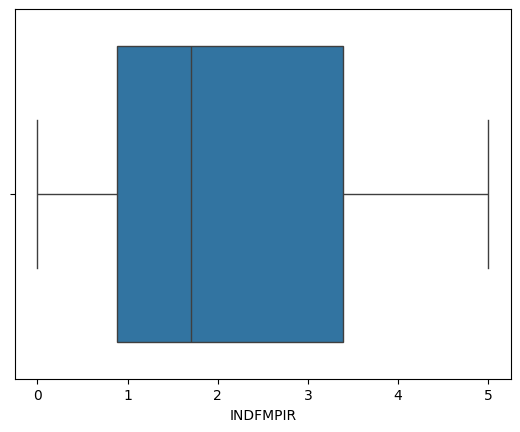

In [59]:
# Boy Arya and Neha
# Using INDFMPIR to predict PERMTH_INT
# INDFMPIR is the Poverty Income Ratio (ratio of Family Income to Poverty Threshold)

import seaborn as sns
sns.boxplot(x=df['INDFMPIR']) 
# about 25% of people fell below the poverty threshold, indicating they were living in poverty
# about 25% of people were above the poverty threshold but are at a greater risk of falling into poverty
# about 50% of people seem to live comfortable lives, financially
# no outliers in INDFMPIR


In [60]:
import numpy as np
np.sum(df['INDFMPIR'].isna(), axis=0)

# there are 1483 missing values for INDFMPIR

np.int64(1483)

In [61]:
df[['INDFMPIR', 'PERMTH_INT']].corr()

,INDFMPIR,PERMTH_INT
INDFMPIR,1.000000,0.109559
PERMTH_INT,0.109559,1.000000


The poverty income ratio is a ratio of family income to the poverty threshold, and would be an interesting variable that could be used to predict moratlity rate and life expectancy. From the box and whisker plot, there seems to be a slight right skew in the income ratio variable, but there are no outliers. Additionally, the plot also shows that around 25% of people interviewed were living in poverty (below a value of 1), 25% of people interviewed were living above the poverty threshold but rather uncomfortabely (just above 1), and 50% of the people interviewed seemed to be living financially comfortable lives. The poverty income ratio and the life expectancy variables are somewhat correlated (especially when compared to the correlations between other variables and life expectancy), with a correlation of 0.109559. 

### Part 2: $k$-NN classification/regression, write-up (50/100 pts)

Submit a notebook that clearly addresses the following, using code and markdown chunks:

1. Describe the data, particularly what an observation is and whether there are any missing data that might impact your analysis. Who collected the data and why? What known limitations are there to analysis? (10/100 pts)


In [62]:
# Eshal

'''
What is an observation? 
Each row in our merged dataset is one NHANES 1999 to 2000 participant (identified by SEQN) with their survey variables plus linked mortality information (MORTSTAT, PERMTH_INT, ELIGSTAT) from the Linked Mortality File.

Who collected the data and why?
The National Center for Health Statistics (CDC) collected NHANES using interviews and physical exams in mobile examination centers to monitor the health and nutritional status of the civilian, non institutionalized U.S. population and track disease risk factors over time. Mortality follow up is added by NCHS through probabilistic linkage of NHANES participants to the National Death Index, yielding vital status, follow up months, and cause of death up to a fixed censoring date.

Missing data that might impact our analysis
Important missingness includes: (a) participants who are not linkage eligible (missing mortality outcomes), (b) public use perturbation of some follow up times and causes of death, and (c) substantial item nonresponse and subsampling in NHANES exam/lab components, which can leave many predictors missing and reduce usable sample size if we rely on complete case analysis.

Known limitations
Key limitations are:
The complex survey design and weights are not fully incorporated in standard kNN, so our models are predictive for this sample, not strictly nationally representative.
Mortality outcomes involve probabilistic linkage and some data perturbation, which introduce outcome error and cap achievable performance.
PERMTH_INT is right censored follow up time, but we treat it as a fully observed regression target instead of using survival methods, which can bias life expectancy predictions.
Many risk factors are measured once and with error, and we only use a subset of available variables, so important predictors may be omitted, and models trained on 1999 to 2000 data may not generalize to today’s population.

'''

'\nWhat is an observation? \nEach row in our merged dataset is one NHANES 1999 to 2000 participant (identified by SEQN) with their survey variables plus linked mortality information (MORTSTAT, PERMTH_INT, ELIGSTAT) from the Linked Mortality File.\n\nWho collected the data and why?\nThe National Center for Health Statistics (CDC) collected NHANES using interviews and physical exams in mobile examination centers to monitor the health and nutritional status of the civilian, non institutionalized U.S. population and track disease risk factors over time. Mortality follow up is added by NCHS through probabilistic linkage of NHANES participants to the National Death Index, yielding vital status, follow up months, and cause of death up to a fixed censoring date.\n\nMissing data that might impact our analysis\nImportant missingness includes: (a) participants who are not linkage eligible (missing mortality outcomes), (b) public use perturbation of some follow up times and causes of death, and (c

2. Describe the variables you selected to predict mortality and life expectancy, and the rationale behind them. Analyze your variables using describe tables, kernel densities, scatter plots, and conditional kernel densities. Are there any patterns of interest to notice? (10/100 pts)

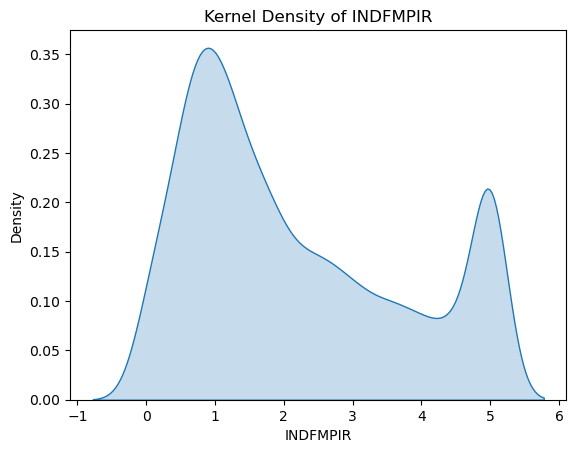

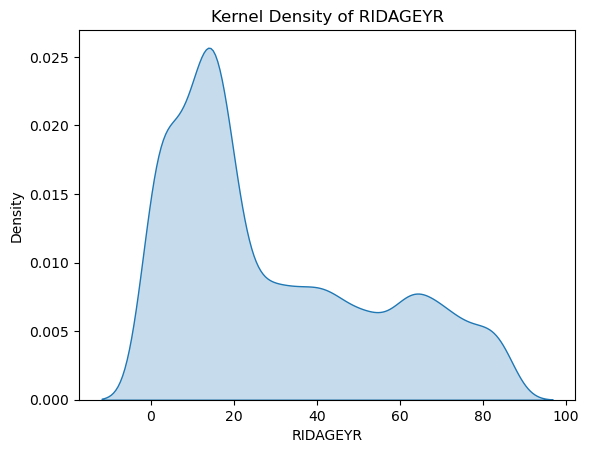

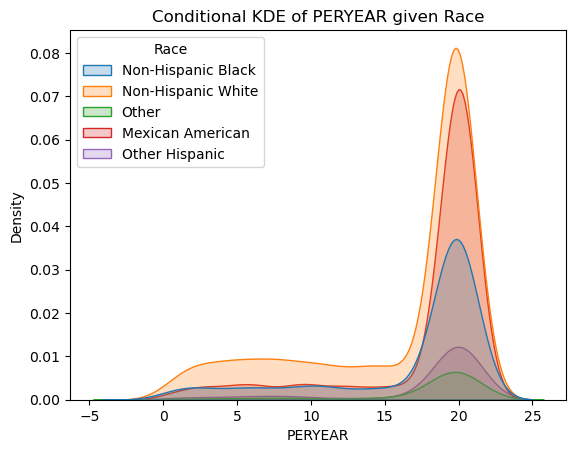

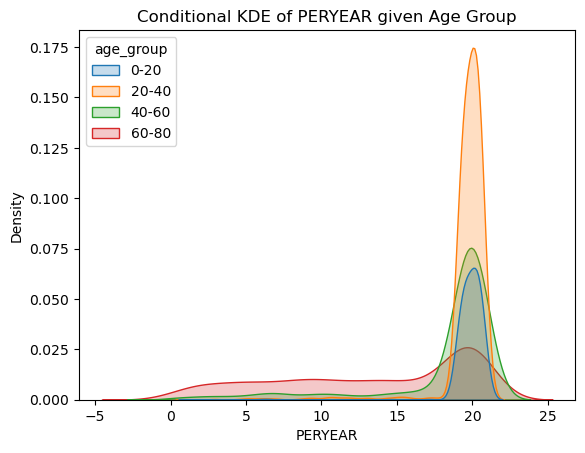

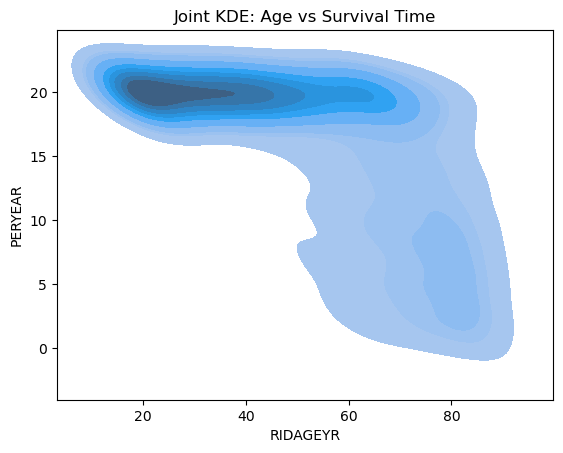

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

variables = ['INDFMPIR', 'RIDRETH1', 'DMDBORN', 'RIDAGEYR']
targets = ['MORTSTAT', 'PERMTH_INT']

# Convert months to years for better interpretability
df['PERYEAR'] = df['PERMTH_INT'] / 12
targets.append('PERYEAR')

# Mappings
race_map = {
    1: "Mexican American",
    2: "Other Hispanic",
    3: "Non-Hispanic White",
    4: "Non-Hispanic Black",
    5: "Other"
}

birth_map = {
    1: "Born in US",
    2: "Born in Mexico",
    3: "Born Elsewhere"
}

mort_map = {
    0: "Alive",
    1: "Deceased"
}

# Apply mappings
df['Race'] = df['RIDRETH1'].map(race_map)
df['Country of Birth'] = df['DMDBORN'].map(birth_map)
df['Mortality Status'] = df['MORTSTAT'].map(mort_map)

# KDE plots for numeric variables
for var in ['INDFMPIR', 'RIDAGEYR']:  # Only numeric variables
    plt.figure()
    sns.kdeplot(data=df, x=var, fill=True)
    plt.title(f'Kernel Density of {var}')
    plt.show()

# Conditional KDE of survival time by Race
plt.figure()
sns.kdeplot(
    data=df,
    x='PERYEAR',
    hue='Race',  # Use mapped labels
    fill=True
)
plt.title("Conditional KDE of PERYEAR given Race")
plt.show()

# Age groups
df['age_group'] = pd.cut(
    df['RIDAGEYR'],
    bins=[0, 20, 40, 60, 80],
    labels=['0-20', '20-40', '40-60', '60-80']
)

# Conditional KDE of survival time by Age Group
plt.figure()
sns.kdeplot(
    data=df,
    x='PERYEAR',
    hue='age_group',
    fill=True
)
plt.title("Conditional KDE of PERYEAR given Age Group")
plt.show()

# Joint KDE: Age vs Survival Time
plt.figure()
sns.kdeplot(
    data=df,
    x='RIDAGEYR',
    y='PERYEAR',
    fill=True
)
plt.title("Joint KDE: Age vs Survival Time")
plt.show()

           INDFMPIR     RIDRETH1      DMDBORN      RIDAGEYR   PERMTH_INT
count  8.482000e+03  9965.000000  9954.000000  9.965000e+03  5445.000000
mean   2.175533e+00     2.561365     1.264617  2.972885e+01   202.314601
std    1.581478e+00     1.268133     0.592749  2.483034e+01    67.137767
min    5.397605e-79     1.000000     1.000000  5.397605e-79     0.000000
25%    8.800000e-01     1.000000     1.000000  1.100000e+01   194.000000
50%    1.700000e+00     3.000000     1.000000  1.900000e+01   235.000000
75%    3.390000e+00     4.000000     1.000000  4.800000e+01   242.000000
max    5.000000e+00     5.000000     9.000000  8.500000e+01   250.000000
Mortality Status
Alive       3770
Deceased    1675
Name: count, dtype: int64
Race
Mexican American      3393
Non-Hispanic White    3367
Non-Hispanic Black    2228
Other Hispanic         589
Other                  388
Name: count, dtype: int64
Country of Birth
Born in US        8069
Born in Mexico    1146
Born Elsewhere     737
Name: count, d

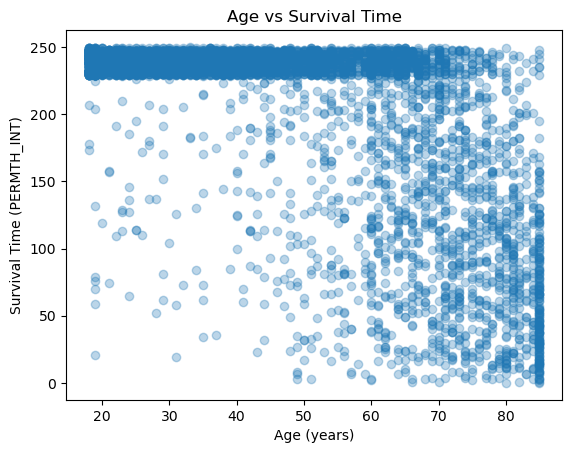

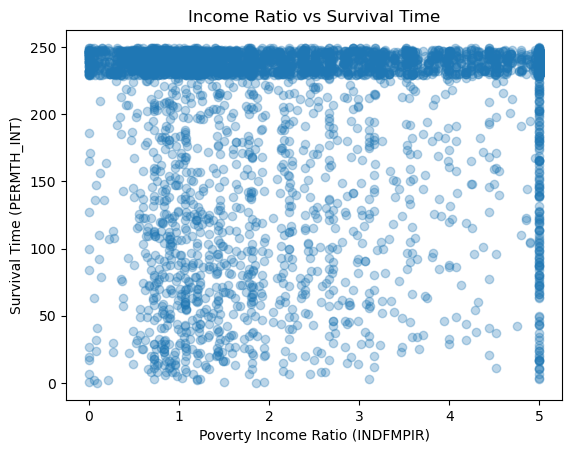

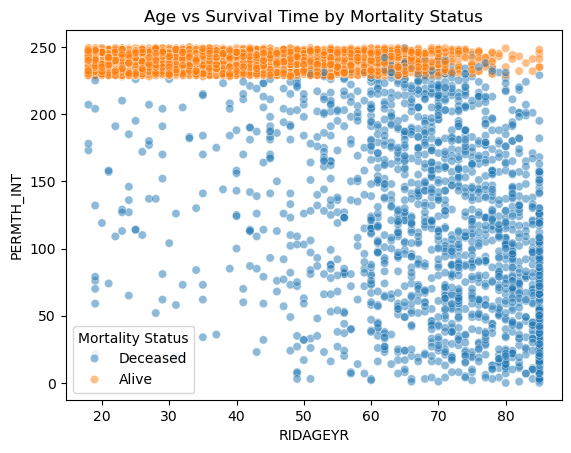

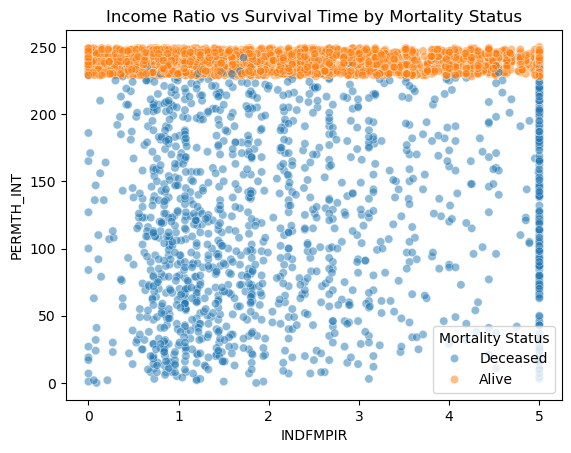

In [14]:
# describe tables for numeric variables
print(df[variables + ['PERMTH_INT']].describe())

# mortality counts
print(df['Mortality Status'].value_counts())

# race counts
print(df['Race'].value_counts())

# country of birth counts
print(df['Country of Birth'].value_counts())

### SCATTERPLOTS 

# age vs survival time 
plt.figure()
plt.scatter(df['RIDAGEYR'], df['PERMTH_INT'], alpha=0.3)
plt.xlabel("Age (years)")
plt.ylabel("Survival Time (PERMTH_INT)")
plt.title("Age vs Survival Time")
plt.show()

# poverty ratio vs survival time
plt.figure()
plt.scatter(df['INDFMPIR'], df['PERMTH_INT'], alpha=0.3)
plt.xlabel("Poverty Income Ratio (INDFMPIR)")
plt.ylabel("Survival Time (PERMTH_INT)")
plt.title("Income Ratio vs Survival Time")
plt.show()

# age vs survival time, colored by mortality
plt.figure()
sns.scatterplot(data=df, x='RIDAGEYR', y='PERMTH_INT', hue='Mortality Status', alpha=0.5)
plt.title("Age vs Survival Time by Mortality Status")
plt.show()

# income ratio vs survival time, colored by mortality
plt.figure()
sns.scatterplot(data=df, x='INDFMPIR', y='PERMTH_INT', hue='Mortality Status', alpha=0.5)
plt.title("Income Ratio vs Survival Time by Mortality Status")
plt.show()

The scatterplots show a clear relationship between age and survival team, as younger individuals are much more likely to have long survival times clustered near the upper limit, while older individuals are more spread out (so they include many shorter survival times). When grouped by mortality status, deaths are concetrated at higher ages and lower survival times, while most living individuals are clustered at high survival times across ages. 

The income ratio shows a much weaker pattern, but lower income values tend to be associated with more short survival times and more deaths, whereas higher income values are more concentrated among those long survival times. 

3. Using your variables to predict mortality using a $k$-Nearest Neighbor Classifier. Analyze its performance and explain clearly how you select $k$. (10/100 pts)

In [ ]:
# Shalmali

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

target = 'MORTSTAT'
data = df[variables + [target]].dropna()   # drop missing values

X = data[variables]
y = data[target]

k_list = [1,5,11,17,27,37,49,57,67,77,89,99,105,117,127,137,149,157,167,177,189,199]
acc_values = []

# split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# test different k values and store accuracy to find the optimal k (value of k that results in highest accuracy)
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    acc_values.append(acc)

best_k = k_list[acc_values.index(max(acc_values))]
print("Best k:", best_k)
print("Best accuracy:", max(acc_values))


''' 
The performance of the classifier is decent as the accuracy is ~86% which is much better than random guessing (50% for binary classification). 
The confusion matrix shows the majority of values are along the main diagonal, indicating that the model is correctly classifying most of the cases.
'''

# train final model with best k and evaluate
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_scaled, y_train)
y_pred_best = best_knn.predict(X_test_scaled)

# confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
print("Confusion matrix:")
print(cm)

Best k: 67
Best accuracy: 0.8621064060803475
Confusion matrix:
[[586  45]
 [ 82 208]]


4. Using your variables to predict life expectancy using a $k$-Nearest Neighbor Regressor. Analyze its performance and explain clearly how you select $k$. (10/100 pts)

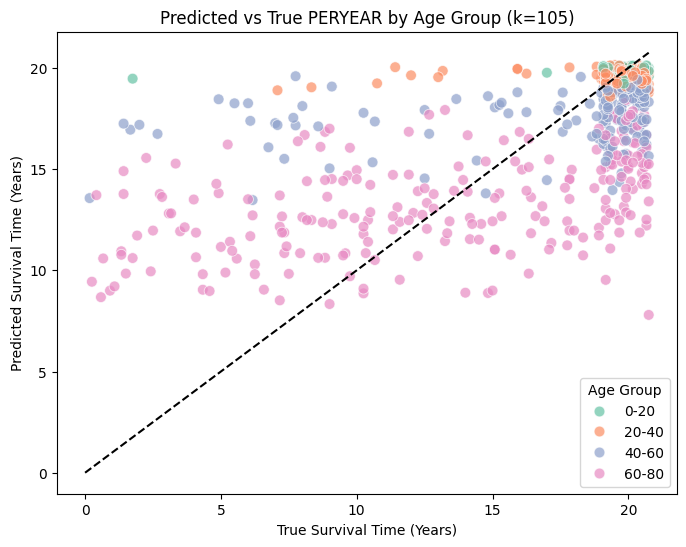

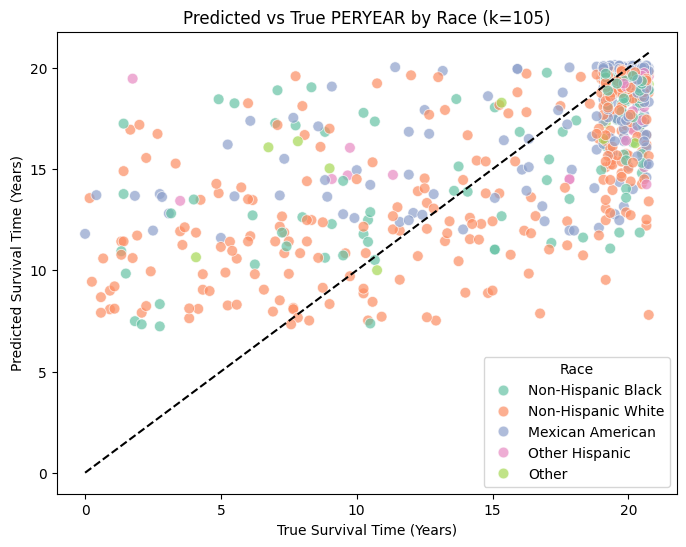

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert test target and predictions to years
y_test_years = y_test / 12
y_pred_years = y_pred_best / 12

# Merge predictions with test set and age
test_df = X_test.copy()
test_df['True'] = y_test_years
test_df['Predicted'] = y_pred_years
# Add age info for coloring
test_df['age_group'] = df.loc[X_test.index, 'age_group']

# Scatterplot: predicted vs true, colored by age group
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=test_df,
    x='True',
    y='Predicted',
    hue='age_group',
    palette='Set2',
    s=60,
    alpha=0.7
)

plt.xlabel("True Survival Time (Years)")
plt.ylabel("Predicted Survival Time (Years)")
plt.title(f"Predicted vs True PERYEAR by Age Group (k={best_k})")
plt.plot(
    [test_df['True'].min(), test_df['True'].max()],
    [test_df['True'].min(), test_df['True'].max()],
    color='black',
    linestyle='--'
)

plt.legend(title="Age Group")
plt.show()

# Scatterplot: by race
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=test_df,
    x='True',
    y='Predicted',
    hue=df.loc[X_test.index, 'Race'],  # map numeric codes to Race labels
    palette='Set2',
    s=60,
    alpha=0.7
)

plt.xlabel("True Survival Time (Years)")
plt.ylabel("Predicted Survival Time (Years)")
plt.title(f"Predicted vs True PERYEAR by Race (k={best_k})")
plt.plot(
    [test_df['True'].min(), test_df['True'].max()],
    [test_df['True'].min(), test_df['True'].max()],
    color='black',
    linestyle='--'
)

plt.legend(title="Race")
plt.show()

The kernel density and scatterplots show a large concentration of individuals at the maximum observed survival time. This occurs because many participants were still alive at the end of the study period. Their true lifespan exceeds the observed value, but we are unaware of this because the study window ended. This produces a sharp boundary or “wall” in the plots–a pattern that was also observable in the KDE comparing survival time with age. As a result, survival time predictions are less precise, especially for younger and healthier individuals who did not experience the event during follow-up. We can see from the predicted and true value scatterplot conditioned by age that a lot of the younger individuals are clustered toward the 20 year mark, indicating the end of the study period. This default value makes it harder to predict the true life expectancy. This shows an inherent flaw in the data collection method, rather than a flaw in our constructed model. 

In [66]:
print(y_test.mean())
print(y_pred_best.mean())

203.24755700325733
204.81123002947106


5. Describe how your model could be used for health interventions based on patient characteristics. Are there any limitations or risks to consider? (10/100 pts)

In [67]:
# Girl Arya


## Submission (10/100 pts)

Submit your work in a well-organized GitHub repo, where the code is appropriately commented and all members of the group have made significant contributions to the commit history. (10/100 pts)